## Step 1 - Climate Analysis and Exploration

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Declare a Base using `automap_base()`
Base = automap_base()

# reflect an existing database into a new model
Base.prepare(engine, reflect=True)

# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Get the column names in the measurement table
measurement_data = session.query(Measurement).first()
measurement_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f669da5b70>,
 'date': '2010-01-01',
 'prcp': 0.08,
 'id': 1,
 'station': 'USC00519397',
 'tobs': 65.0}

# Exploratory Climate Analysis

### Precipitation Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#-----------------------------------------------------------------------------------------
# Get the last data point in the database
max_date = session.query(func.max(Measurement.date)).first()
last_date = dt.datetime.strptime(max_date[0], '%Y-%m-%d').date()
print(f"Last date as datetime:  {last_date}")

# Calculate the date 1 year ago from the last data point in the database
yearago_date = last_date - dt.timedelta(days=365)
print(f"One year ago:  {yearago_date}")

Last date as datetime:  2017-08-23
One year ago:  2016-08-23


In [11]:
# Perform a query to retrieve the data and precipitation scores
result_set = session.query(Measurement.prcp, Measurement.date).\
             filter(Measurement.prcp != "None").\
             filter(Measurement.date >= yearago_date).\
             filter(Measurement.date <= last_date).all()

# Save the query results as a Pandas DataFrame
prcp_data = pd.DataFrame(result_set)

# Sort the dataframe by date
prcp_data.sort_values('date', ascending=True, inplace=True)
prcp_data.head()

,prcp,date
0,0.00,2016-08-23
1027,0.02,2016-08-23
702,0.05,2016-08-23
1693,0.70,2016-08-23
359,0.15,2016-08-23


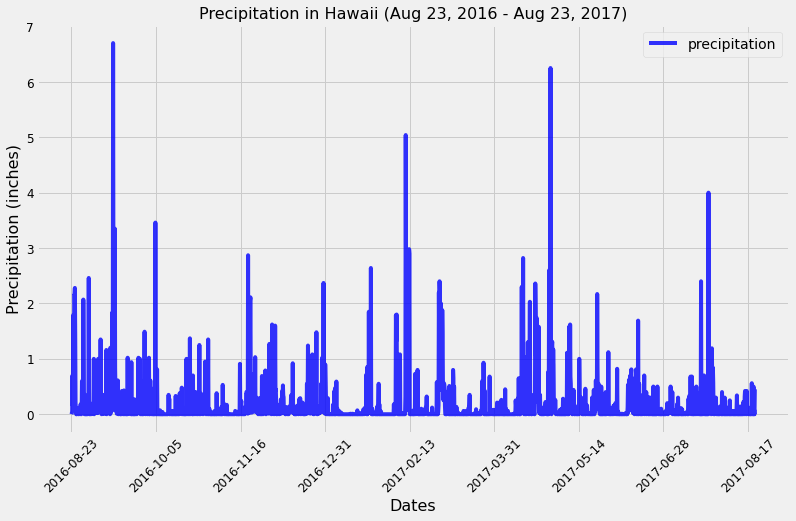

In [12]:
# Plot the precipitation data for the last year available in the dataset
prcp_data.plot(x='date', y='prcp', color='b', fontsize=12, alpha=.8,  figsize=(12,7), rot=45)
plt.ylabel("Precipitation (inches)", fontsize=16)
plt.xlabel("Dates", fontsize=16)
plt.title(f"Precipitation in Hawaii ({format(yearago_date, '%b %d, %Y')} - {format(last_date, '%b %d, %Y')})", fontsize=16)
plt.legend(['precipitation'])
plt.savefig("output/precipitation.png")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data.rename(columns={'prcp':'precipitation'}, inplace=True)
prcp_data.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [14]:
# View the column names in the Station table
# station_data = session.query(Station).first()
# station_data.__dict__

In [15]:
# Inspect the column names in the Station table
from sqlalchemy import inspect
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [16]:
# Design a query to show how many stations are available in this dataset?
no_of_stations = session.query(Station.station).distinct().count()
print(f"Number of Stations : {no_of_stations}")

Number of Stations : 9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
              filter(Measurement.station == Station.station).\
              group_by(Measurement.station).\
              order_by(func.count(Measurement.station).desc()).first()
print(f"Most active station:  {most_active.station}")

# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
filter(Measurement.station == Station.station).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

Most active station:  USC00519281


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
result = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station == most_active.station)
print(f"Station : {most_active.station}")
print(f"Minimum Temperature : {result[0][0]} \nMaximum Temperature : {result[0][1]}")
print(f"Average Temperature : {result[0][2]}")

Station : USC00519281
Minimum Temperature : 54.0 
Maximum Temperature : 85.0
Average Temperature : 71.66378066378067


Station with highest number of observations :  USC00519281
Number of observations for the station USC00519281 : 2772


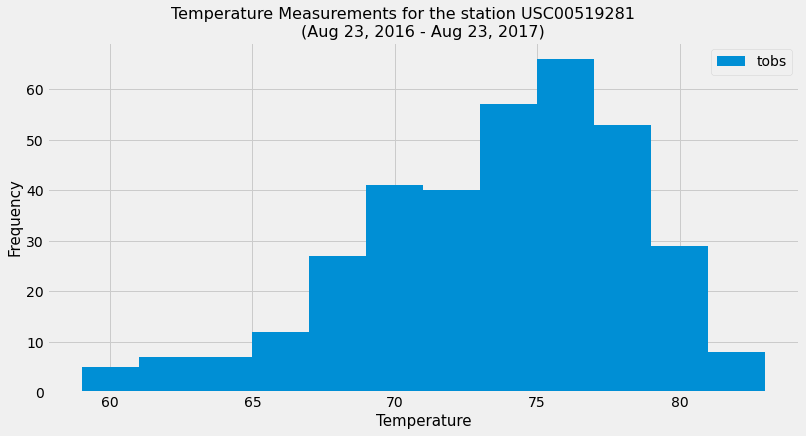

In [19]:
# Choose the station with the highest number of temperature observations.
print(f"Station with highest number of observations :  {most_active.station}")
print(f"Number of observations for the station {most_active.station} : {most_active[1]}")

# Query the last 12 months of temperature observation data for this station
tobs_data = session.query(Measurement.tobs).\
        filter(Measurement.station == most_active.station).\
        filter(Measurement.date.between(yearago_date, last_date)).all()

# and plot the results as a Histogram
plt.figure(figsize=(12,6))
plt.hist(np.ravel(tobs_data), bins=12)       # convert the tobs_data result set into an array and plot
plt.title(f"Temperature Measurements for the station {most_active.station}\
        \n({format(yearago_date, '%b %d, %Y')} - {format(last_date, '%b %d, %Y')})", fontsize=16)
plt.xlabel("Temperature", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.legend(['tobs'])
plt.savefig("output/histogram.png")
plt.show()

## Bonus Challenge Assignment

### Temperature Analysis I

###### Q.  Will you use a paired t-test, or an unpaired t-test? Why?

    The sample data here is the average temperature of the selected stations in June/Summer and December/Winter. It is the  same group or set of stations where the the temperature readings are taken in two different times of the year. It is a  dependant group and so we have to use paired t-test.


In [20]:
conn = engine.connect()

In [21]:
# Identify the average temperature in June at all stations across all available years
june_tobs = pd.read_sql_query("select station, avg(tobs) as avgtobs, strftime('%m', datetime(date)) as month from measurement where month='06' group by station", conn)
june_tobs

,station,avgtobs,month
0,USC00511918,74.139394,06
1,USC00513117,74.050847,06
2,USC00514830,76.005376,06
3,USC00516128,71.937220,06
4,USC00517948,76.655405,06
5,USC00518838,73.394737,06
6,USC00519281,73.271186,06
7,USC00519397,77.559322,06
8,USC00519523,76.668103,06


In [22]:
#Identify the average temperature in December at all stations across all available years
december_tobs = pd.read_sql_query("select station, avg(tobs) as avgtobs, strftime('%m', datetime(date)) as month from measurement  where month='12' group by station", conn)
december_tobs

,station,avgtobs,month
0,USC00511918,69.684211,12
1,USC00513117,71.069444,12
2,USC00514830,73.224719,12
3,USC00516128,69.291262,12
4,USC00517948,71.834862,12
5,USC00518838,72.421053,12
6,USC00519281,69.903226,12
7,USC00519397,71.109524,12
8,USC00519523,72.433333,12


In [23]:
from scipy.stats import ttest_rel
ttest_rel(june_tobs['avgtobs'], december_tobs['avgtobs'])

Ttest_relResult(statistic=6.95696617044294, pvalue=0.00011759380231523222)

###### Q. Use the t-test to determine whether the difference in the means, if any, is statistically significant.

    Statistically, there is a significant difference in Hawaii temperature between June and December because the pvalue = 0.00011759380231523222 which is less than 0.5. 

### Temperature Analysis II

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


#### Trip dates : 2018-01-01  to   2018-01-11

In [25]:
trip_start = dt.datetime(2018, 5, 2)
trip_end = dt.datetime(2018, 5, 14)

# previous year start and end for the same dates
yearago_startdt = (trip_start - dt.timedelta(days=365)).date()
yearago_enddt = (trip_end - dt.timedelta(days=365)).date()
print(f"{yearago_startdt}      {yearago_enddt}")

2017-05-02      2017-05-14


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

tmin, tavg, tmax = calc_temps(yearago_startdt, yearago_enddt)[0]
print(f"{tmin}  {tavg}  {tmax}")

66.0  75.48611111111111  80.0


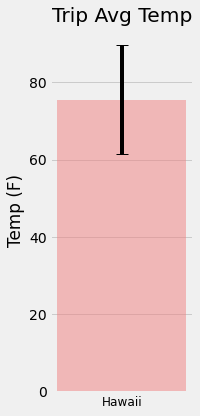

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
yerr = tmax-tmin
ax.bar([0], tavg, yerr=yerr, align='center', color = 'lightcoral', alpha=0.5, ecolor='black', capsize=6)
ax.set_ylabel('Temp (F)')
ax.set_xlabel('Hawaii', fontsize=12)
ax.set_xticks([])
ax.set_title('Trip Avg Temp')
# ax.yaxis.grid(True)
fig.set_figwidth(3)
fig.set_figheight(6)
# Save the figure and show
plt.tight_layout()
plt.savefig('output/temp_errorbar.png')
plt.show()

### Daily Rainfall Average

In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_data = session.query(Measurement.station, func.sum(Measurement.prcp), \
            Station.name, Station.latitude, Station.longitude, Station.elevation)\
            .filter(Measurement.station == Station.station)\
            .filter(Measurement.date >= yearago_startdt)\
            .filter(Measurement.date <= yearago_enddt)\
            .group_by(Measurement.station)\
            .order_by(func.sum(Measurement.prcp).desc()).all()

for eachrow in rainfall_data:
    print(eachrow)

('USC00516128', 3.6600000000000006, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00519281', 2.9800000000000004, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00513117', 2.1399999999999997, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00514830', 1.91, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
('USC00519523', 0.74, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00519397', 0.01, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)


In [31]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [32]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = trip_start
end_date = trip_end

# Use the start and end date to create a range of dates
date_range = pd.date_range(start_date, end_date)

# Stip off the year and save a list of %m-%d strings
date_list = []
for eachdate in date_range:
    mmdd = dt.datetime.strftime(eachdate, '%m-%d')
    date_list.append(mmdd)

# Loop through the list of %m-%d strings and calculate the normals for each date
normals_list = []

for item in date_list:
    temp = daily_normals(item)
    normals_list.append({'tMin':temp[0][0], 
                         'tAvg':temp[0][1], 'tMax':temp[0][2]})
normals_list

[{'tMin': 65.0, 'tAvg': 73.05084745762711, 'tMax': 79.0},
 {'tMin': 67.0, 'tAvg': 73.41071428571429, 'tMax': 84.0},
 {'tMin': 65.0, 'tAvg': 73.59649122807018, 'tMax': 78.0},
 {'tMin': 67.0, 'tAvg': 73.39655172413794, 'tMax': 79.0},
 {'tMin': 66.0, 'tAvg': 73.14035087719299, 'tMax': 80.0},
 {'tMin': 64.0, 'tAvg': 71.78846153846153, 'tMax': 79.0},
 {'tMin': 65.0, 'tAvg': 72.18867924528301, 'tMax': 80.0},
 {'tMin': 67.0, 'tAvg': 72.9322033898305, 'tMax': 79.0},
 {'tMin': 64.0, 'tAvg': 73.3157894736842, 'tMax': 78.0},
 {'tMin': 65.0, 'tAvg': 73.61111111111111, 'tMax': 79.0},
 {'tMin': 65.0, 'tAvg': 73.13793103448276, 'tMax': 79.0},
 {'tMin': 67.0, 'tAvg': 73.14285714285714, 'tMax': 79.0},
 {'tMin': 63.0, 'tAvg': 73.89285714285714, 'tMax': 80.0}]

In [33]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normal_df = pd.DataFrame(normals_list)
daily_normal_df['date'] = date_range.astype(str)
daily_normal_df

,tMin,tAvg,tMax,date
0,65.0,73.050847,79.0,2018-05-02
1,67.0,73.410714,84.0,2018-05-03
2,65.0,73.596491,78.0,2018-05-04
3,67.0,73.396552,79.0,2018-05-05
4,66.0,73.140351,80.0,2018-05-06
5,64.0,71.788462,79.0,2018-05-07
6,65.0,72.188679,80.0,2018-05-08
7,67.0,72.932203,79.0,2018-05-09
8,64.0,73.315789,78.0,2018-05-10
9,65.0,73.611111,79.0,2018-05-11


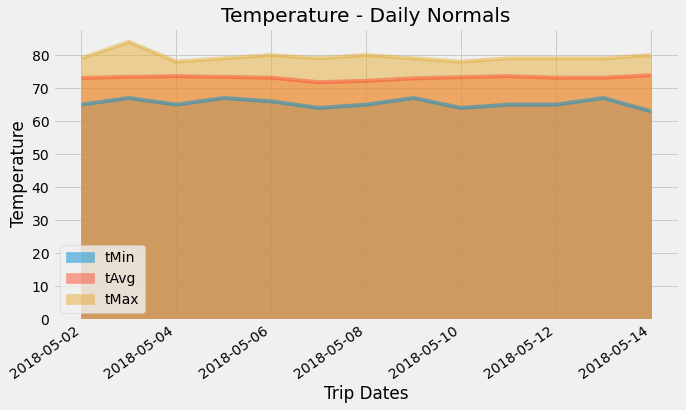

In [34]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normal_df.plot(kind='area', x='date', stacked = False, figsize=(10,5), rot=35)
plt.xlabel("Trip Dates")
plt.ylabel("Temperature")
plt.title("Temperature - Daily Normals")
plt.xticks(ha='right')
plt.savefig("output/daily_normals.png")
plt.show()